In [1]:
# Requires xarray_sentinel environment

import os
import sys 
import glob
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
# TODO perform analysis (averaging) along axis to see whether noise is present since no denoising is performed

In [4]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"

f0 = 5.3E9
z0 = 700E3
c = 3E8
Lambda = c / f0
length_antenna = 3.2
height_antenna = 0.3
incidence_angle_scat = 40
incidence_angle_scat_boresight = 45
vx_sat = 6800 
PRF = 4
stride = vx_sat / PRF
az_mask_cutoff = 40_000 # m
resolution_spatial = 200 # m
scene_size = 12500
az_mask_pixels_cutoff = int(az_mask_cutoff/2//resolution_spatial)

In [6]:
# Load files
files = glob.glob(f"{data_dir}*")
NRCS = grd_to_nrcs(files[2], prod_res=resolution_spatial,  denoise=True)

/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  calibration_vv = xr.open_dataset(path,
/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:60: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constru

Calibrate VV
Denoising VV


/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:85: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dd_vh = xr.open_dataset(path, engine="sentinel-1", group='IW/VH')
/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the Da

Calibrate VH
Denoising VH


/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:13: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  gcps = xr.open_dataset(path, engine="sentinel-1", group='IW/VV/gcp')
/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:14: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the

In [17]:
# Select date and location to querry ERA5
path = '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/'
date = NRCS.azimuth_time.min().values.astype('datetime64[m]').astype(object)
date_rounded = round_to_hour(date)

yy, mm, dd, hh = date_rounded.year, date_rounded.month, date_rounded.day, date_rounded.hour
latmin = latmax = NRCS.latitude.mean().data*1
lonmin = lonmax = NRCS.longitude.mean().data*1

era5_filename = getera5(latmin, latmax, lonmin, lonmax, yy, mm, dd, hh, path=path, retrieve=True)

2023-11-14 16:56:45,263 INFO Welcome to the CDS
2023-11-14 16:56:45,263 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-14 16:56:45,371 INFO Request is completed
2023-11-14 16:56:45,372 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data6/adaptor.mars.internal-1699969730.270564-27903-19-1a4dc71e-df49-4212-b28b-688c44deb139.nc to /Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/era520201104.nc (1.3K)
2023-11-14 16:56:45,556 INFO Download rate 7.2K/s


In [18]:
# Compute wind speed and direction from ERA5
filename = era5_filename.split(path)[1]
era5 = xr.open_dataset(filename)
u10, v10 = np.ravel(era5.u10.values*1)[0], np.ravel(era5.v10.values*1)[0]
wdir_era5 = np.rad2deg(np.arctan2(u10, v10))

# Compute orientation of observation
lats, lons = NRCS.latitude.values, NRCS.longitude.values
geodesic = pyproj.Geod(ellps='WGS84')
ground_dir, _, _ = geodesic.inv(lons[0, 0], lats[0, 0], lons[-1,0], lats[-1,0])

# compute directional difference between satelite and era5 wind direction
wdir_wrt_sensor = angular_difference(ground_dir, wdir_era5)

In [19]:
# create dataframe with coordinates from scatterometer 
grg_offset = np.tan(np.deg2rad(incidence_angle_scat)) * z0
grg = np.arange(NRCS.latitude.data.shape[1]) * resolution_spatial + grg_offset
az = (np.arange(NRCS.latitude.data.shape[0]) - NRCS.latitude.data.shape[0]//2) * resolution_spatial
x_sat = np.arange(az.min(), az.max(), stride)

data = xr.Dataset(
    data_vars=dict(
        nrcs = (["az", "grg"], NRCS.NRCS_VV.data, {'units': 'm2/m2'}),
        inc = (["az", "grg"], NRCS.inc.data, {'units': 'Degrees'}),
        x_sat = (["slow_time"], x_sat)
    ),
    coords=dict(
        az = (["az"], az, {'units': 'm'}),
        grg = (["grg"], grg, {'units': 'm'}),
    ),
    attrs=dict(wdir_wrt_sensor=wdir_wrt_sensor),
)

In [20]:
# convert S1 backscatter to windfield and back to equivalent scatterometer backscatter
windfield = cmod5n_inverse(data.nrcs.values, data.wdir_wrt_sensor, data.inc.values)
windfield = np.tile(windfield,  data.slow_time.shape + (1,1)) # expand the windfield from 2D to 3D
data['windfield'] = (["slow_time", "az", "grg"], windfield, {'units': 'm/s'})

def windfield_over_slow_time(data_subset):
    result = cmod5n_forward(data_subset.windfield.values, data_subset.wdir_wrt_sensor, data_subset.inc_scatt_eqv.values)
    data_subset['nrcs_scatt'] = (["az", "grg"], result, {'units': 'm/s'})
    return data_subset

# calculate surface distance between sensor and point on surface as well as equivalent incidence angle for sensor
data['distance_ground'] = calculate_distance(x = data.az, y = data.grg, x0 = data.x_sat) 
data['inc_scatt_eqv'] = np.rad2deg(np.arctan(data['distance_ground']/z0))
data = data.groupby('slow_time').apply(windfield_over_slow_time).transpose('az', 'grg', 'slow_time')

In [21]:
# compute relative weight from backscatter and azimuth and 
data['nrcs_weight'] = (data.nrcs_scatt / data.nrcs_scatt.mean(dim=['az', 'grg'])) # NOTE weight is linearly scaled with relative nrcs (e.g. local nrcs of twice the average will yield weight of 2.0)
data['distance_slant_range'] = np.sqrt(data['distance_ground']**2 + z0**2)
data['az_angle_wrt_boresight'] = np.arcsin((- data.x_sat + data.az )/data['distance_slant_range']) # incidence from boresight
data['grg_angle_wrt_boresight'] = np.deg2rad(data['inc_scatt_eqv'] - incidence_angle_scat_boresight)
data = data.transpose('az', 'grg', 'slow_time')

# calculate beam patterns
data['beam_grg'] = (['az', 'grg', 'slow_time'], sinc_bp(np.sin(data['az_angle_wrt_boresight']), L=length_antenna, f0=f0))
data['beam_az'] = (['az', 'grg', 'slow_time'], sinc_bp(np.sin(data['grg_angle_wrt_boresight']), L=height_antenna, f0=f0))
data['beam_grg_az'] = data['beam_grg'] * data['beam_az']

In [22]:
# compute beam mask around 
top_row = np.abs(data.beam_grg_az.sum(dim='grg')).argmax(axis=0).values
masks = []
for i in top_row:
    mask = np.zeros_like(data['az'])  # create a mask
    lower_limit = np.where(i-az_mask_pixels_cutoff < 0, 0, i-az_mask_pixels_cutoff)
    mask[lower_limit:i+az_mask_pixels_cutoff+1] = 1
    masks.append(mask)

temp = xr.Dataset(
    data_vars=dict(
        temp1 = (["az","slow_time"], np.array(masks).T), 
        temp2 = (["grg"], np.ones_like(data.grg))),
    coords=dict(
        az=(["az"], data['az'].values),
        grg=(["grg"], data['grg'].values),
        time_slow=(["slow_time"], data['slow_time'].values),),
)

data['beam_mask'] = temp.temp1 * temp.temp2

In [23]:
data['dop_geom'] = (2 * vx_sat * np.sin(data.az_angle_wrt_boresight) / Lambda) # eq. 4.34 from Digital Procesing of Synthetic Aperture Radar Data by Ian G. Cummin
data['beam'] = data['beam_grg_az'] * data['beam_mask'] 
data['dop_beam_weighted'] = data['dop_geom'] * data['beam']* data['nrcs_weight']

Text(0.5, 1.0, 'Tapered beam pattern [-]')

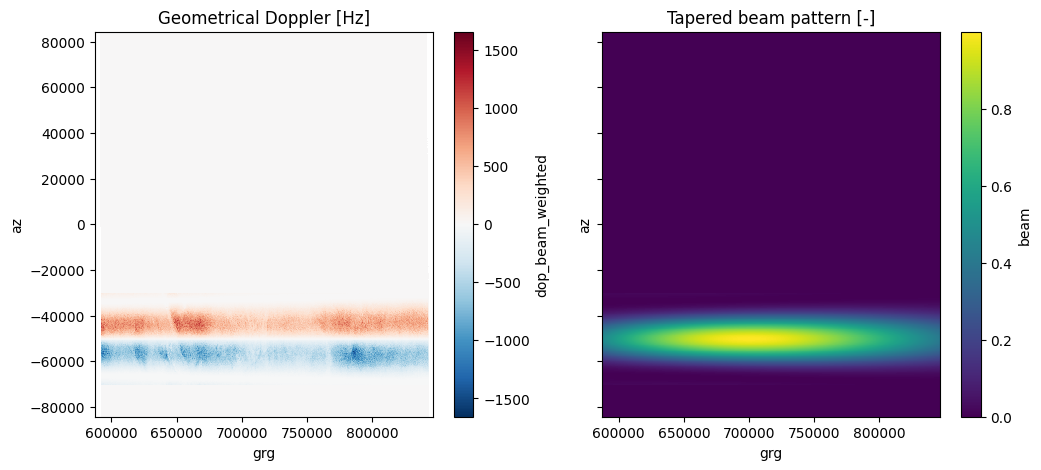

In [24]:
idx = 20
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
data['dop_beam_weighted'].isel(slow_time = idx).plot(ax = axes[0])
data['beam'].isel(slow_time = idx).plot(ax = axes[1])
axes[0].set_title('Geometrical Doppler [Hz]')
axes[1].set_title('Tapered beam pattern [-]')

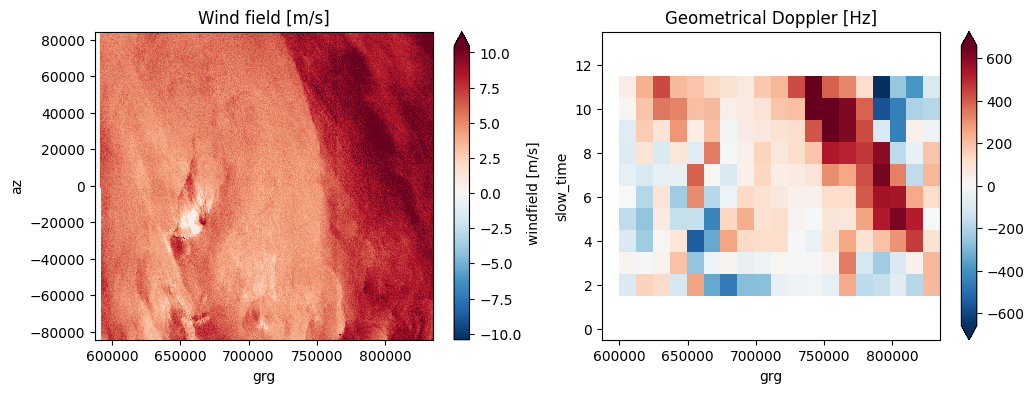

In [25]:
grg_N = int(scene_size // resolution_spatial)
slow_time_N = int(scene_size // stride)
subscene = data[['beam', 'dop_beam_weighted']].coarsen(grg=grg_N, slow_time=slow_time_N, boundary='trim').sum(skipna=False) 

gridded_doppler = (subscene['dop_beam_weighted']/subscene['beam']).mean(dim='az').T
beam_cutoff =subscene['beam'].sum(dim = ['az', 'grg'])/ subscene['beam'].sum(dim = ['az', 'grg']).max() < 0.9995
gridded_doppler[beam_cutoff,:] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
data.windfield.isel(slow_time=0).plot(robust= True, ax=axes[0])
gridded_doppler.plot(robust = True)
axes[0].set_title('Wind field [m/s]')
_ = axes[1].set_title('Geometrical Doppler [Hz]')